# Recreation of Figure 3 (a)
Grouping probabilities $p_{g}(x)$ as a function of the hyperbolic distance x between TLD+1 nodes. 

### 1. Load the nodes coordinates file.

In [10]:
import re, json

# The nodes coordinates of the TLD+1 network  
f_name = "../Datasets/EdgeList_TLD.inf_coord"

header_map = {
    "Vertex": "id",
    "Inf.Kappa": "kappa",
    "Inf.Theta": "theta_rad",
    "Inf.Hyp.Rad.": "r"
}

# The final dataset
dataset = {}
# The output header variables
header = []
# The network nodes 
nodes = []
# The embedding parameters
parameters = {}

# Read the Mercator output file line by line
with open(f_name, "r") as fp:
    for l in fp.readlines():
        # Line cleanup step
        line = re.sub(' +', ' ', l.strip())
        # Process Comment line
        if line.startswith("#"):
            # Extract parameters
            if " - " in line:
                tmp = line.replace("# - ", "").split(": ")
                parameters[tmp[0]] = float(tmp[1])
            # Extract data header
            elif line.startswith("# Vertex"):
                tmp = line.replace("# ", "").split(" ")
                for e in tmp:
                    header.append(header_map[e])
        else: # Process nodes data
            tmp = line.split(" ")
            t = {}
            for k, v in zip(header, tmp):
                t[k] = v
            nodes.append(t)

dataset["parameters"] = parameters
dataset["nodes"] = nodes

print("# of nodes: {}".format(len(dataset["nodes"])))

# of nodes: 1847


In [11]:
# Dictionary to hold the nodes' attributes, theta ("t") and radius ("r").
NDict = {}

# Loop through all nodes and cast their attributes from string to float.
for n in dataset["nodes"]:
    # Cast string values into float
    NDict[n["id"]] = {
        "t": float(n["theta_rad"]),
        "r": float(n["r"])
    }

# Get all node ids to create all possible links between them.
all_n_ids = NDict.keys()

print("# of node ids: {}".format(len(all_n_ids)))

# of node ids: 1847


### 2. Prepare all node combinations and estimate the hyperbolic distance between them. 

In [12]:
import math
import itertools
from tqdm.notebook import tqdm

# Function to calculate the hyperbolic distance between two nodes
def distance(i, j):
    ti = i["t"]
    tj = j["t"]
    ri = i["r"]
    rj = j["r"]
    
    theta = abs(ti - tj)
    
    if theta > math.pi:
        theta = 2 * math.pi - theta
    
    if theta == 0.0:
        return abs(ti-tj)
    
    return math.acosh( (math.cosh(ri) * math.cosh(rj)) - (math.sinh(ri) * math.sinh(rj) * math.cos(theta)) )

# Variable to hold the distance between all node combinations
Comb = {}

with tqdm(total=(len(all_n_ids) * (len(all_n_ids)-1))/2, desc="Pairs done") as pbar:
    for i, j in itertools.combinations(all_n_ids, 2):
        dist = distance(NDict[i], NDict[j])
        Comb[i + " " + j] = dist
        pbar.update(1)

print("All link combinations: {}".format(len(Comb)))

Pairs done:   0%|          | 0/1704781.0 [00:00<?, ?it/s]

All link combinations: 1704781


In [13]:
# Also load the domains mapping to organizations that we will need later
import json

ORG_MAP = {}

with open("legal-entities_list.json", "r") as fp:
    TMP_MAP = json.load(fp)

for e in TMP_MAP:
    if e['domain'] not in ORG_MAP:
        ORG_MAP[e['domain']] = e['legal']
    else:
        print(e['domain'], e['legal'], ORG_MAP[e['domain']])
    
print("ORG_MAP length: {}".format(len(ORG_MAP))) # ORG_MAP length: 7524

ORG_MAP length: 1847


### 3. Estimate Hyperbolic Distance

In [14]:
import operator

# Assign nodes to bins based on their hyperbolic distance.
def create_bins(combinations, step, debug=False):
    # First we sort all pairs based on their hyperbolic distance
    sorted_dist = sorted(combinations.items(), key=operator.itemgetter(1), reverse=True)
    s_f = sorted_dist.copy()

    # Variables to allow us to assign nodes to different hyperbolic distance bins
    bin_min = 0
    bin_max = step
    counter = 0
    bin = str(bin_max)
    # To hold the final pairs in each bin
    res = {}
    # Initialize the first bin
    res[bin] = []

    N = s_f.pop()
    while len(s_f) != 0:
        dist = N[1]
        if dist >= bin_max:
            if debug: print(bin, counter, len(res[bin]), N)
            bin_min = bin_max
            bin_max += step
            counter = 0
            bin = str(bin_max)
        if bin not in res:
            res[bin] = []
        if dist <= bin_max and dist >= bin_min:
            res[bin].append(N)
            N = s_f.pop()
            counter += 1

    # To handle the last node N from s_f.pop() above. 
    while True:
        dist = N[1]
        if dist >= bin_max:
            if debug: print(bin, counter, len(res[bin]), N)
            bin_min = bin_max
            bin_max += step
            counter = 0
            bin = str(bin_max)
        if bin not in res:
            res[bin] = []
        if dist <= bin_max and dist >= bin_min:
            res[bin].append(N)
            counter += 1
            break
    if debug: print(bin, counter, len(res[bin]), N)
    return res

# Estimate the grouping probability per bin and return the plot data
def create_plot_data(bins, org_map, step, debug=False):
    labels = []
    props = []
    pos_counter = 0
    DETAILS = {"bins": {}, "pairs": []}

    for b in bins:
        z = len(bins[b])
        m = 0
        for c in bins[b]:
            t = c[0].split(" ")
            src = t[0]
            dst = t[1]
            if org_map[src] == org_map[dst]:
                m += 1
                DETAILS["pairs"].append({
                    'bin': b,
                    'position': pos_counter,
                    'tld_src': t[0],
                    'tld_dst': t[1],
                    'legal_src': src,
                    'legal_dst': dst,
                    'parent_src': org_map[src],
                    'parent_dst': org_map[dst]
                })
            pos_counter += 1

        m_z = 0

        # Estimate the grouping probability
        if z != 0:
            m_z = m/z

        DETAILS['bins'][b] = {
            "all": z,
            "found": m,
            "percentage": m_z,
        }  

        if debug: print(b, z, m, m_z)
        if z > 0: # Exclude bins with no observations
            labels.append(b)
            props.append(m_z)
        else:
            labels.append(b)
            props.append(None)
    
    # Export also binning statistics to create the figure 4 plots.
    with open("../Figure4/Bins_Stats_EdgeList_TLD_step_" + str(step) + ".json", "w") as fp:
        json.dump(DETAILS, fp, indent=2)

    return labels, props

In [15]:
# Define the hyperbolic distance binning step
STEP = 3

In [16]:
# Assigned nodes to bins based on their hyperbolic distance.
BINS = create_bins(combinations=Comb, step=STEP, debug=False)
print("# of bins: {}".format(len(BINS)))

# of bins: 24


In [17]:
# Prepare data for plotting
labels, props = create_plot_data(bins=BINS, org_map=ORG_MAP, step=STEP, debug=False)
print("# of labels: {}\n# of props: {}".format(len(labels), len(props)))

# of labels: 24
# of props: 24


In [22]:
# Discriminatory Power
merged_seen = 0

ALL_PAIRS = set(Comb.keys())

for p in ALL_PAIRS:
    #print(p.split(" "))
    t = p.split(" ")
    src = t[0]
    dst = t[1]
    if ORG_MAP[src] == ORG_MAP[dst]:
        merged_seen += 1
    #()+1

disc_power = merged_seen/len(ALL_PAIRS)

print("Discriminatory Power: {}\nBaseline Probability: {}".format(disc_power, merged_seen/len(ALL_PAIRS)*100))

Discriminatory Power: 0.004188221243667075
Baseline Probability: 0.4188221243667075


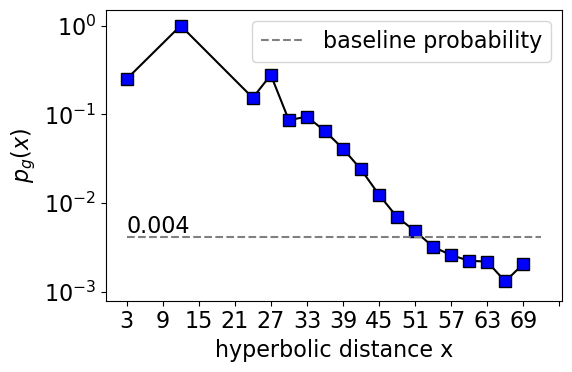

In [24]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from matplotlib.ticker import MaxNLocator

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

pp = PdfPages("Grouping_probability_step_" + str(STEP) + ".pdf")
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=100)
disc_power_l = [disc_power for x in labels]

xs = np.arange(len(labels))
np_props = np.array(props).astype(np.double)
masks = np.isfinite(np_props)

ax1.set_xlabel('hyperbolic distance x')
ax1.plot(xs[masks][:-1],  np_props[masks][:-1], 'ks-',  markersize=8, markerfacecolor="b", markeredgewidth=1.0, markeredgecolor="black", color="black")

ax1.plot(np.arange(len(labels)),  disc_power_l, linestyle='--', color='grey', label = 'baseline probability')
ax1.text(disc_power, disc_power+0.0004, "{:.3f}".format(disc_power), transform=ax1.transData)

ax1.tick_params(axis='y') 
ax1.set_xticks(range(len(labels)))
ax1.set_ylabel('$p_{g}(x)$')
ax1.set_xticklabels(labels)
ax1.tick_params(axis='x', labelrotation = 0)
ax1.xaxis.set_major_locator(MaxNLocator(nbins=15))

plt.yscale('log')
plt.legend()
ax1.set_ylim([0.0008, 1.5])
ax1.set_yticks([1, 0.1, 0.001], minor=True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig(pp, format='pdf')
pp.close()